### Verificando qtd das classes do conjunto de treino, validação e teste
- Datasets:
    - F3
    - Parihaka

In [1]:
import lightning as L
import numpy as np
import torch
import torch.nn.functional as F
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.transforms.transform import _Transform
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pathlib import Path
import os
import random

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# f3
annotation_path_f3 = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
annotation_path_parihaka = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

In [ ]:
EXECUTE_DATASET = 'f3' # f3 / parihaka

if EXECUTE_DATASET == 'f3':
    train_label_reader = PNGReader(Path(annotation_path_f3) / "train")
    val_label_reader = PNGReader(Path(annotation_path_f3) / "val")
    test_label_reader = PNGReader(Path(annotation_path_f3) / "test")
elif EXECUTE_DATASET == 'parihaka':
    train_label_reader = PNGReader(Path(annotation_path_parihaka) / "train")
    val_label_reader = PNGReader(Path(annotation_path_parihaka) / "val")
    test_label_reader = PNGReader(Path(annotation_path_parihaka) / "test")

In [4]:
# Lista para armazenar as labels
all_labels_train = []

# Itera sobre as imagens de label
for i in range(len(train_label_reader)):
    label = train_label_reader[i]  # Leia a label (shape: 255, 701)
    all_labels_train.append(label.flatten())  # Achata para 1D e armazena

# Concatena todas as labels em um único array
all_labels_train = np.concatenate(all_labels_train)

# Conta a ocorrência de cada classe
unique_labels_train, counts_train = np.unique(all_labels_train, return_counts=True)

In [5]:
# Lista para armazenar as labels
all_labels_val = []

# Itera sobre as imagens de label
for i in range(len(val_label_reader)):
    label = val_label_reader[i]  # Leia a label (shape: 255, 701)
    all_labels_val.append(label.flatten())  # Achata para 1D e armazena

# Concatena todas as labels em um único array
all_labels_val = np.concatenate(all_labels_val)

# Conta a ocorrência de cada classe
unique_labels_val, counts_val = np.unique(all_labels_val, return_counts=True)

In [6]:
# Lista para armazenar as labels
all_labels_test = []

# Itera sobre as imagens de label
for i in range(len(test_label_reader)):
    label = test_label_reader[i]  # Leia a label (shape: 255, 701)
    all_labels_test.append(label.flatten())  # Achata para 1D e armazena

# Concatena todas as labels em um único array
all_labels_test = np.concatenate(all_labels_test)

# Conta a ocorrência de cada classe
unique_labels_test, counts_test = np.unique(all_labels_test, return_counts=True)

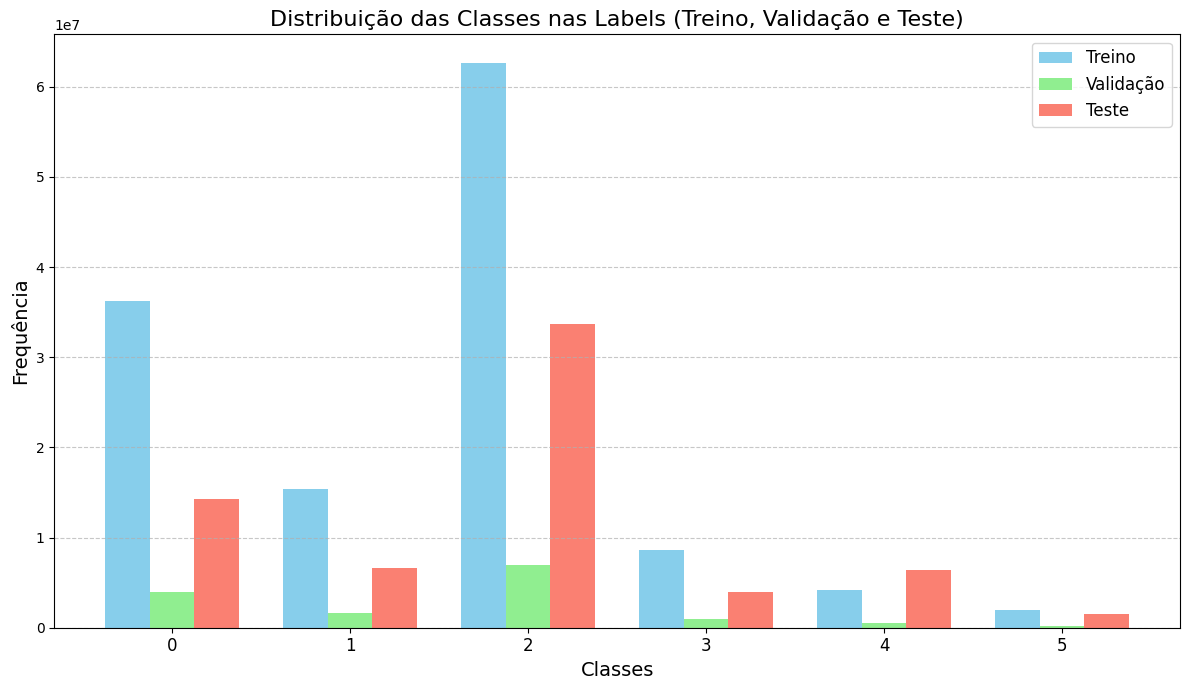

In [7]:
# Configurações para o gráfico de barras agrupadas
x = np.arange(len(unique_labels_train))  # Posições para as classes
width = 0.25  # Largura das barras

# Cria o gráfico
plt.figure(figsize=(12, 7))

# Adiciona as barras para cada conjunto
plt.bar(x - width, counts_train, width, label="Treino", color='skyblue')
plt.bar(x, counts_val, width, label="Validação", color='lightgreen')
plt.bar(x + width, counts_test, width, label="Teste", color='salmon')

# Configurações do gráfico
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.title("Distribuição das Classes nas Labels (Treino, Validação e Teste)", fontsize=16)
plt.xticks(x, unique_labels_train, fontsize=12)  # Define os rótulos das classes no eixo X
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostra o gráfico
plt.show()

### Verificando iou das classes do modelo treinado
- Datasets:
    - F3
    - Parihaka

In [1]:
import lightning as L
import numpy as np
import torch
import torch.nn.functional as F
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.transforms.transform import _Transform
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pathlib import Path
import os
import random

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


#### Preparando dados

In [2]:
# f3
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

In [3]:
from scipy.ndimage.interpolation import zoom

class RandomGeneratorForImage(_Transform):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, sample: np.ndarray) -> np.ndarray:
        channels, x, y = sample.shape
        
        # Redimensiona cada canal individualmente para evitar o erro de dimensão
        resized_channels = [
            zoom(sample[c], (self.output_size[0] / x, self.output_size[1] / y), order=3)
            for c in range(channels)
        ]
        
        # Converte a lista de canais redimensionados de volta para um array numpy e, em seguida, para um tensor PyTorch
        image = np.stack(resized_channels, axis=0).astype(np.float32)
        image = torch.from_numpy(image)
        return image

class RandomGeneratorForLabel(_Transform):
    def __init__(self, output_size):
        self.output_size = output_size
        # self.low_res = low_res

    def __call__(self, sample: np.ndarray) -> np.ndarray:
        label = sample

        x, y = label.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        label = torch.from_numpy(label.astype(np.float32))
        return label.long()

transformImage = RandomGeneratorForImage((512, 512))
transformLabel = RandomGeneratorForLabel((512, 512))

/tmp/ipykernel_143891/3589103371.py:1: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [4]:
import cv2
from patchify import patchify

def rotate_and_flip_patch(patch_img, patch_label):
    rotate = cv2.ROTATE_90_CLOCKWISE
    # Rotaciona -90 graus (equivalente a transpor e depois inverter verticalmente)
    patch_img_rotated = cv2.rotate(patch_img, rotate)
    patch_label_rotated = cv2.rotate(patch_label, rotate)
    # Espelha horizontalmente
    patch_img_flipped = cv2.flip(patch_img_rotated, 1)
    patch_label_flipped = cv2.flip(patch_label_rotated, 1)
    return patch_img_flipped, patch_label_flipped

def resize_image(image, target_shape):
    return cv2.resize(image, target_shape, interpolation=cv2.INTER_LINEAR)

def cria_patchs_sismicas(images, labels, patch_size=(512,512), step=512):
    all_img_patches = []
    all_label_patches = []
    for i, large_image in enumerate(images): # iterando as imagens
        # plt.figure(figsize=(8, 8))
        # plt.imshow(cv2.cvtColor(np.array(large_image), cv2.COLOR_BGR2RGB))  # Convertendo BGR para RGB para visualização correta
        # plt.title("large_image")
        # plt.axis('off')
        # plt.show()
        # Garantir que a imagem está deitada
        # if large_image.shape[0] > large_image.shape[1]:
        #     large_image = cv2.rotate(np.array(large_image), cv2.ROTATE_90_CLOCKWISE)
        #     label = cv2.rotate(np.array(labels[i]), cv2.ROTATE_90_CLOCKWISE)
        
        target_shape = ((large_image.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_image.shape[0] // patch_size[0] + 1) * patch_size[0])
        
        large_image_resized = resize_image(np.array(large_image), target_shape)
        # print("large_image shape:", large_image.shape)
        # print("large_image type:", type(large_image))
        # print("Target shape:", target_shape)
        # print("large_image_resized shape:", large_image_resized.shape)
        # print("large_image_resized type:", type(large_image_resized))
        # print("patch_size shape:", patch_size)
        # print("step shape:", step)

        # # Plotando a imagem redimensionada
        # plt.figure(figsize=(8, 8))
        # plt.imshow(cv2.cvtColor(np.array(large_image), cv2.COLOR_BGR2RGB))  # Convertendo BGR para RGB para visualização correta
        # plt.title("large_image")
        # plt.axis('off')
        # plt.show()

        # Garantir que os rótulos também tenham o tipo correto
        label = np.array(labels[i]).astype(np.uint8)
        
        # plt.figure(figsize=(8, 8))
        # plt.imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))  # Convertendo BGR para RGB para visualização correta
        # plt.title("labels")
        # plt.axis('off')
        # plt.show()
        
        large_label_resized = resize_image(label, target_shape)
        # print("label")
        # print("Original label shape:", label.shape)
        # print("Target shape:", target_shape)
        # print("Resized shape:", large_label_resized.shape)
        # print("patch_size shape:", patch_size)
        # print("step shape:", step)
        
        # Verifica se as dimensões redimensionadas são múltiplos exatos do patch_size
        assert large_image_resized.shape[0] % patch_size[0] == 0, "Altura da imagem não é múltipla do patch_size."
        assert large_image_resized.shape[1] % patch_size[1] == 0, "Largura da imagem não é múltipla do patch_size."
        assert large_label_resized.shape[0] % patch_size[0] == 0, "Altura da label não é múltipla do patch_size."
        assert large_label_resized.shape[1] % patch_size[1] == 0, "Largura da label não é múltipla do patch_size."
        # plt.imshow(large_image)
        # plt.show()
        # plt.imshow(large_image_resized)
        # plt.show()

        patches_img = patchify(large_image_resized, patch_size=patch_size + (3,), step=step)
        # print(len(patches_img), patches_img.shape)
        patches_label = patchify(large_label_resized, patch_size=patch_size, step=step)
        # print(len(patches_label), patches_label.shape)

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, 0]  # Remove a dimensão extra da Imagem
                single_patch_label = patches_label[i, j]  # Remove a dimensão extra da Label
                
                # Converte o patch da imagem para float32
                single_patch_img = np.transpose(single_patch_img, (2, 0, 1)).astype(np.float32)
                # Converte o patch do rótulo para int64 (long)
                single_patch_label = single_patch_label.astype(np.int64)
                
                # single_patch_img, single_patch_label = rotate_and_flip_patch(single_patch_img, single_patch_label) # Aplica a rotação e espelhamento
                # print(single_patch_img.shape, single_patch_label.shape)
                # plt.imshow(single_patch_img)
                # plt.title(f"Patch ({i}, {j})")
                # plt.axis('off')
                # plt.show()
                # plt.imshow(single_patch_label)
                # plt.title(f"Patch ({i}, {j})")
                # plt.axis('off')
                # plt.show()
                # single_patch_img = np.transpose(single_patch_img, (2, 0, 1))
                # single_patch_label = np.transpose(single_patch_label, (2, 0, 1))
                
                all_img_patches.append(single_patch_img)
                all_label_patches.append(single_patch_label)
        # break
    return np.array(all_img_patches), np.array(all_label_patches)

In [5]:
class F3DataModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        transforms: _Transform = None,
        batch_size: int = 1,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReader(self.train_path / "train")
            train_label_reader = PNGReader(self.annotations_path / "train")

            # # Dividir 80/20 para treino e validação
            # num_train_samples = int(len(train_img_reader) * 0.8)
            # indices = list(range(len(train_img_reader)))
            # random.shuffle(indices)
            # # train_indices = indices[:num_train_samples]
            # val_indices = indices[num_train_samples:] # pegar só 20%

            # train_img_reader = [train_img_reader[i] for i in val_indices]
            # train_label_reader = [train_label_reader[i] for i in val_indices]
            
            # TODO aplicar patchify, e pra cada (img, label), aplicar o RandomTransform()
            # e só depois jogar no SupervisedReconstructionDataset().
            # Ou então ajeitar o RandomTransform() para enviar diretamente ao SupervisedReconstructionDataset()
            train_imgs, train_labels = cria_patchs_sismicas(train_img_reader, train_label_reader)
            # print(train_imgs.shape)
            # print(train_labels.shape)

            train_dataset = SupervisedReconstructionDataset(
                readers=[train_imgs, train_labels],
                transforms=self.transforms,
            )

            val_img_reader = TiffReader(self.train_path / "val")
            val_label_reader = PNGReader(self.annotations_path / "val")

            # TODO aplicar patchify, e pra cada (img, label), aplicar o RandomTransform()
            # e só depois jogar no SupervisedReconstructionDataset().
            # Ou então ajeitar o RandomTransform() para enviar diretamente ao SupervisedReconstructionDataset()
            val_imgs, val_labels = cria_patchs_sismicas(val_img_reader, val_label_reader)

            val_dataset = SupervisedReconstructionDataset(
                readers=[val_imgs, val_labels],
                transforms=self.transforms,
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReader(self.train_path / "test")
            test_label_reader = PNGReader(self.annotations_path / "test")

            # TODO aplicar patchify, e pra cada (img, label), aplicar o RandomTransform()
            # e só depois jogar no SupervisedReconstructionDataset().
            # Ou então ajeitar o RandomTransform() para enviar diretamente ao SupervisedReconstructionDataset()
            test_imgs, test_labels = cria_patchs_sismicas(test_img_reader, test_label_reader)

            test_dataset = SupervisedReconstructionDataset(
                readers=[test_imgs, test_labels],
                transforms=self.transforms,
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )
    def worker_init_fn(self, worker_id):
        random.seed(18 + worker_id)

data_module = F3DataModule(
    train_path=train_path,
    annotations_path=annotation_path,
    # transforms=transform,
    transforms=[transformImage, transformLabel],
    batch_size=7,
)

#### Avaliação

In [6]:
from lightning.pytorch import LightningModule

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Carregar o modelo salvo
# best_checkpoint = "checkpoints/sam_model-epoch=32-val_loss=0.06.ckpt"  # #1 experimento
# best_checkpoint = "checkpoints/sam_model-current_date=0-epoch=34-val_loss=0.07.ckpt"  # #2 experimento
# best_checkpoint = "checkpoints/sam_model-2024-11-18-epoch=44-val_loss=0.04.ckpt"  # #3 experimento
# best_checkpoint = "checkpoints/sam_model-2024-11-18-epoch=34-val_loss=0.06.ckpt"  # #4 experimento
# best_checkpoint = "checkpoints/sam_model-2024-11-18-epoch=47-val_loss=0.01.ckpt"  # #5 experimento
best_checkpoint = "checkpoints/test-sam_model-2024-11-18-epoch=30-val_loss=0.07.ckpt"  # teste
trained_model = SAMLoRA.load_from_checkpoint(
    checkpoint_path=best_checkpoint,
    image_size=512,
    num_classes=5, # considera 6 pois internamente o sam faz +1 pro background
    alpha=1,
    rank=4).to(device)

cuda
Focal loss alpha=0.25, will shrink the impact in background


In [7]:
# Número de classes
num_classes = 6

In [8]:
import torch
from torchmetrics.classification import MulticlassJaccardIndex
import torchmetrics
import numpy as np

def calculate_metrics(dataloader, model, num_classes):
    model.eval()  # Define o modelo em modo de avaliação
    iou_metric = MulticlassJaccardIndex(num_classes=num_classes, average=None).to(model.device)
    # iou_metric = torchmetrics.JaccardIndex(task="multiclass", num_classes=num_classes).to(model.device)
    
    class_counts = torch.zeros(num_classes, dtype=torch.int32)  # Contagem das classes por amostra
    class_iou = torch.zeros(num_classes, dtype=torch.float32)  # IoU de cada classe
    all_labels = []  # Lista para armazenar todas as labels
    all_preds = []  # Lista para armazenar todas as previsões

    with torch.no_grad():
        for batch in dataloader:
            # low_res = model.img_embedding_size * 4
            image_batch, label_batch = batch[0].to(model.device), batch[1].to(model.device)
            # print("-"*20)
            # print(image_batch.shape)
            # print(label_batch.shape)
            # print("-"*20)
            # label_batch = label_batch  # .squeeze(1)  # Remove a dimensão extra
            # low_res_label_batch = model.make_low_res_label(label=label_batch, low_res=[low_res, low_res]) # batch["low_res_label"]
          
            # Predição
            outputs = model(image_batch, True, image_size=model.image_size)
            # print("mask shape: ", outputs['masks'].shape)

            probs = torch.softmax(outputs['masks'], dim=1)
            preds = torch.argmax(probs, dim=1)  # Obtém a classe predita para cada pixel
            # print("shape preds: ", preds.shape)
            # print("shape preds[0]: ", preds[0].shape)

            # Atualiza o IoU para cada classe
            iou_per_class = iou_metric(preds, label_batch).cpu()
            # print("iou_per_class: ", iou_per_class)
            # print("Frequência em preds:", torch.bincount(preds.flatten(), minlength=num_classes))
            # print("Frequência em labels:", torch.bincount(label_batch.flatten(), minlength=num_classes))

            class_iou += iou_per_class

            # Atualiza a distribuição das classes
            for c in range(num_classes):
                class_counts[c] += torch.sum(preds == c).item()

            # Armazena todas as labels e previsões para análise posterior
            all_labels.append(label_batch.flatten())
            all_preds.append(preds.flatten())
    
    # Concatena todas as labels e previsões para calcular as frequências das classes
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_preds = torch.cat(all_preds).cpu().numpy()

    unique_labels, counts_labels = np.unique(all_labels, return_counts=True)  # Frequência por classe
    unique_preds, counts_preds = np.unique(all_preds, return_counts=True)  # Frequência por classe

    # Calcula o IoU por classe
    class_iou = class_iou / len(dataloader)  # Divide pelo número de batches

    # Distribuição das classes
    class_distribution = class_counts / class_counts.sum()

    return class_iou, class_distribution, unique_labels, counts_labels, unique_preds, counts_preds

In [9]:
# DataLoaders
data_module.setup(stage='fit')
train_loader = data_module.train_dataloader()

# Métricas para treino
train_iou, train_distribution, train_unique_labels, train_counts_labels, train_unique_preds, train_counts_preds = calculate_metrics(train_loader, trained_model, num_classes)
print("Train IoU:", train_iou)
print("Train Class Distribution:", train_distribution)
print("Test count labels:", train_counts_labels)

del train_loader

Train IoU: tensor([0.9830, 0.9061, 0.9803, 0.9394, 0.9258, 0.8298])
Train Class Distribution: tensor([0.2824, 0.1235, 0.4786, 0.0672, 0.0332, 0.0151])
Test count labels: [ 99806851  42250064 172268954  23493895  11557434   5303634]


In [10]:
# DataLoaders
data_module.setup(stage='fit')
val_loader = data_module.val_dataloader()

# Métricas para validação
val_iou, val_distribution, val_unique_labels, val_counts_labels, val_unique_preds, val_counts_preds = calculate_metrics(val_loader, trained_model, num_classes)
print("Validation IoU:", val_iou)
print("Validation Class Distribution:", val_distribution)
print("Test count labels:", val_counts_labels)

del val_loader

Validation IoU: tensor([0.9826, 0.9041, 0.9803, 0.9376, 0.8814, 0.6457])
Validation Class Distribution: tensor([0.2814, 0.1225, 0.4804, 0.0665, 0.0339, 0.0154])
Test count labels: [11028203  4638877 19164061  2577887  1313576   598996]


In [11]:
# DataLoaders
data_module.setup(stage='test')
test_loader = data_module.test_dataloader()

# Métricas para teste
test_iou, test_distribution, test_unique_labels, test_counts_labels, test_unique_preds, test_counts_preds = calculate_metrics(test_loader, trained_model, num_classes)
print("Test IoU:", test_iou)
print("Test Class Distribution:", test_distribution)
print("Test count labels:", test_counts_labels)

del test_loader

Test IoU: tensor([0.9598, 0.8048, 0.9409, 0.6013, 0.4406, 0.3567])
Test Class Distribution: tensor([0.2230, 0.1068, 0.5128, 0.0779, 0.0665, 0.0130])
Test count labels: [ 45414228  21042128 107286171  12506157  18704766   4761750]


* Classe com alta frequência e IoU alto:
    - Exemplo: se a barra para a classe 1 é alta, e o ponto da linha correspondente também é alto, o modelo aproveitou bem os dados disponíveis para predizer essa classe.
    - Esperado para classes comuns.
* Classe com baixa frequência e IoU baixo:
    - Exemplo: se a barra para a classe 4 é baixa, e o ponto da linha correspondente é próximo a 0, o modelo teve dificuldade com essa classe devido à baixa representatividade.
    - Sinal de desbalanceamento ou desafio para o modelo.
* Classe com baixa frequência e IoU alto:
    - Exemplo: se a barra para a classe 5 é baixa, mas o ponto da linha é alto, o modelo generalizou bem para essa classe mesmo com poucos dados.
* Classe com alta frequência e IoU baixo:
    - Exemplo: se a barra para a classe 2 é alta, mas o ponto da linha é baixo, o modelo pode estar tendo dificuldade em distinguir essa classe de outras.

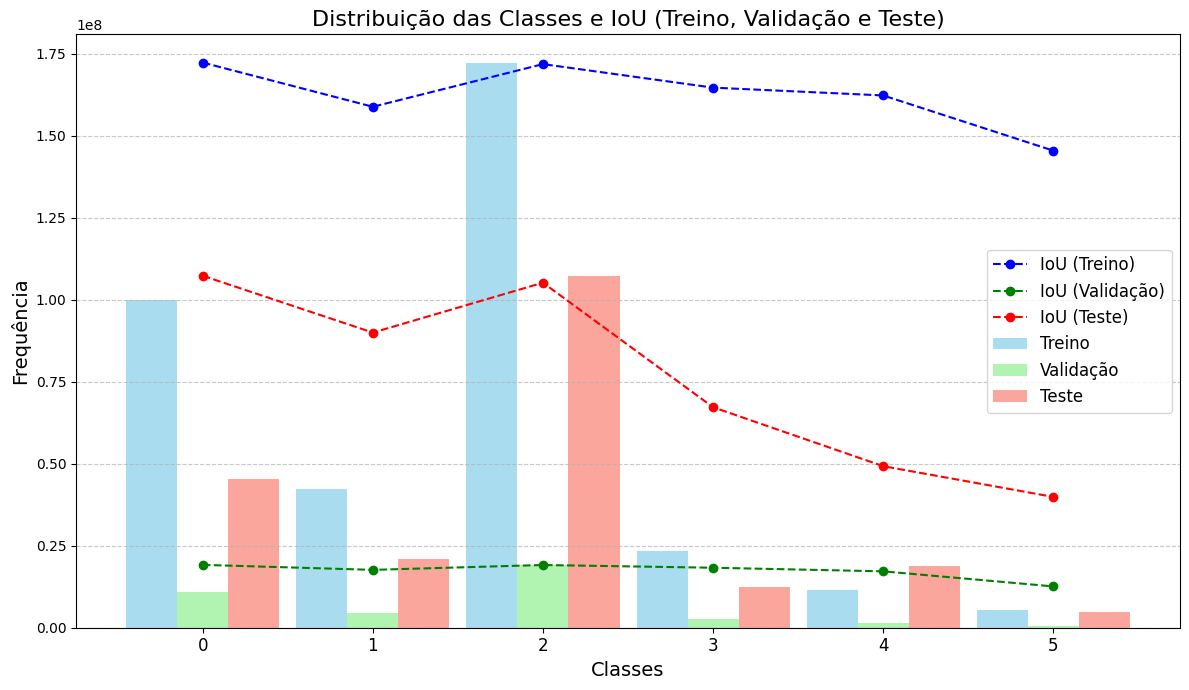

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Configurações para o gráfico de barras e linha
x = np.arange(len(train_unique_labels))  # Posições para as classes
width = 0.3  # Largura das barras

plt.figure(figsize=(12, 7))

# Adiciona as barras para cada conjunto
plt.bar(x - width, train_counts_labels, width, label="Treino", color='skyblue', alpha=0.7)
plt.bar(x, val_counts_labels, width, label="Validação", color='lightgreen', alpha=0.7)
plt.bar(x + width, test_counts_labels, width, label="Teste", color='salmon', alpha=0.7)

# Adiciona a linha para o IoU (normalize para comparação visual)
plt.plot(x, train_iou / train_iou.max() * max(train_counts_labels), 
         label="IoU (Treino)", color='blue', linestyle='--', marker='o')
plt.plot(x, val_iou / val_iou.max() * max(val_counts_labels), 
         label="IoU (Validação)", color='green', linestyle='--', marker='o')
plt.plot(x, test_iou / test_iou.max() * max(test_counts_labels), 
         label="IoU (Teste)", color='red', linestyle='--', marker='o')

# Configurações do gráfico
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.title("Distribuição das Classes e IoU (Treino, Validação e Teste)", fontsize=16)
plt.xticks(x, train_unique_labels, fontsize=12)  # Define os rótulos das classes no eixo X
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostra o gráfico
plt.show()

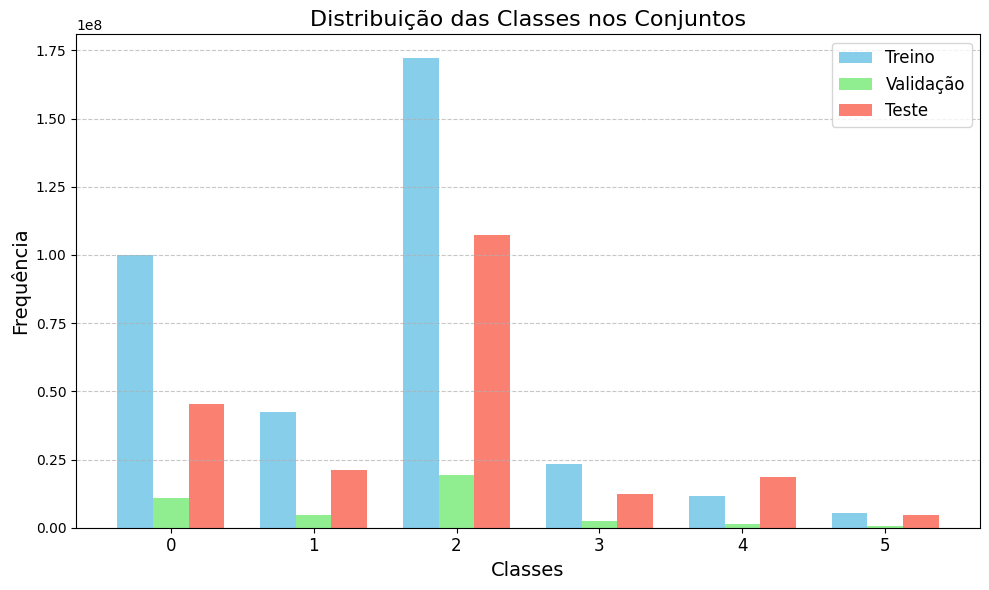

In [13]:
# Frequência das classes
x = np.arange(len(train_unique_labels))  # Posições para as classes
width = 0.25  # Largura das barras

plt.figure(figsize=(10, 6))

# Barras para frequências
plt.bar(x - width, train_counts_labels, width, label="Treino", color='skyblue')
plt.bar(x, val_counts_labels, width, label="Validação", color='lightgreen')
plt.bar(x + width, test_counts_labels, width, label="Teste", color='salmon')

# Configurações do gráfico
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.title("Distribuição das Classes nos Conjuntos", fontsize=16)
plt.xticks(x, train_unique_labels, fontsize=12)  # Define os rótulos das classes no eixo X
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

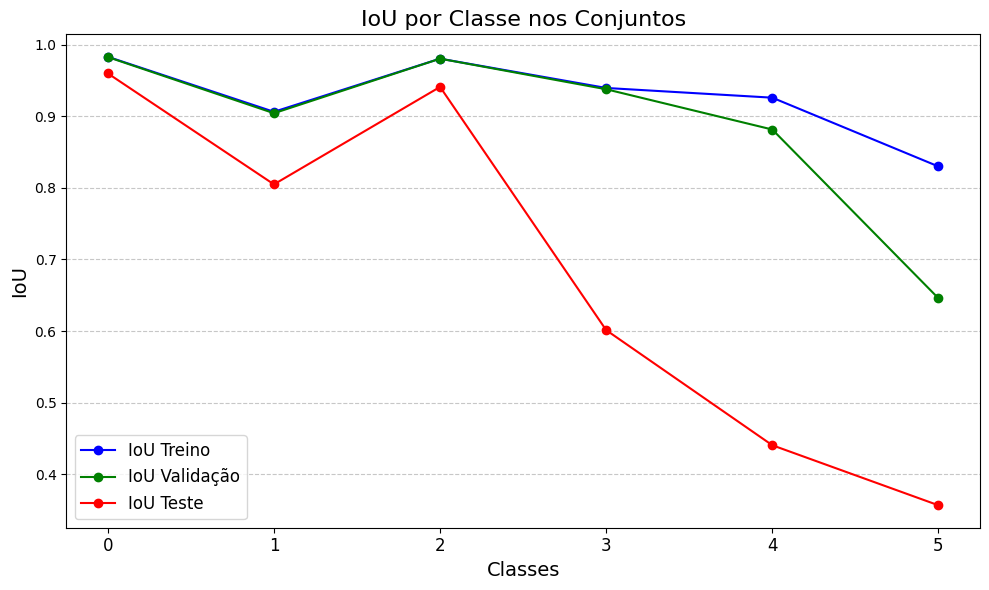

In [14]:
# IoU por classe
x = np.arange(len(train_iou))  # Posições para as classes

plt.figure(figsize=(10, 6))

# Linhas para IoU
plt.plot(x, train_iou, label="IoU Treino", color='blue', marker='o')
plt.plot(x, val_iou, label="IoU Validação", color='green', marker='o')
plt.plot(x, test_iou, label="IoU Teste", color='red', marker='o')

# Configurações do gráfico
plt.xlabel("Classes", fontsize=14)
plt.ylabel("IoU", fontsize=14)
plt.title("IoU por Classe nos Conjuntos", fontsize=16)
plt.xticks(x, train_unique_labels, fontsize=12)  # Define os rótulos das classes no eixo X
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

* Barras bem alinhadas (Predições ≈ Labels Reais):
    - Cenário Ideal: Indica que o modelo está capturando bem as distribuições reais das classes. Isso é ótimo, desde que o desempenho (IoU) esteja alto e uniforme entre as classes.
    - Cuidado com Overfitting: Se o modelo está reproduzindo as distribuições, mas não generalizando (IoU baixo em validação/teste), pode ser que ele esteja "memorizando" as distribuições das labels reais no conjunto de treino.
* Barras desalinhadas (Predições ≠ Labels Reais):
    - Classes com Frequência Alta: O modelo pode estar enviesado para classes majoritárias (frequentes), especialmente se não houver balanceamento nos dados ou técnicas de mitigação de viés.
    - Classes com Frequência Baixa: Classes raras tendem a ser subrepresentadas nas predições, o que pode levar a baixo desempenho nessas classes.

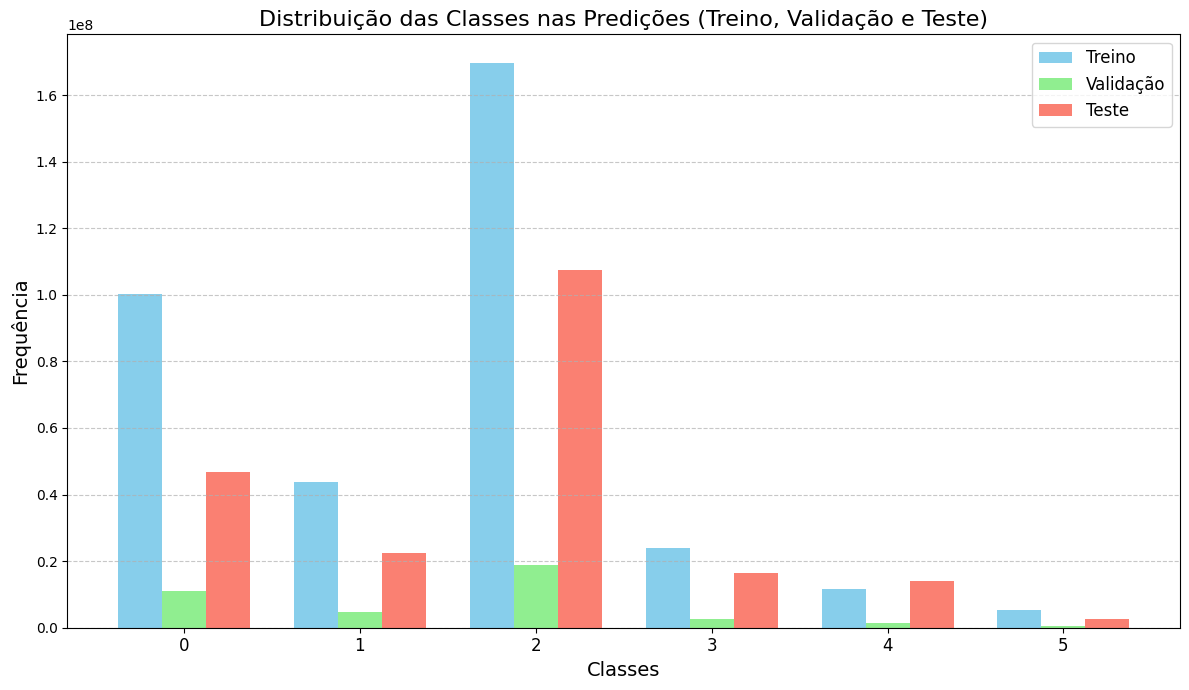

In [15]:
# Configurações para o gráfico de barras agrupadas
x = np.arange(len(train_unique_preds))  # Posições para as classes
width = 0.25  # Largura das barras

# Cria o gráfico
plt.figure(figsize=(12, 7))

# Adiciona as barras para cada conjunto
plt.bar(x - width, train_counts_preds, width, label="Treino", color='skyblue')
plt.bar(x, val_counts_preds, width, label="Validação", color='lightgreen')
plt.bar(x + width, test_counts_preds, width, label="Teste", color='salmon')

# Configurações do gráfico
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.title("Distribuição das Classes nas Predições (Treino, Validação e Teste)", fontsize=16)
plt.xticks(x, train_unique_preds, fontsize=12)  # Define os rótulos das classes no eixo X
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostra o gráfico
plt.show()

#### Interpretação do ChatGPT:

* Barras de Labels Reais vs Predições:
    - Quando as barras para labels reais e predições estão com alturas próximas ou iguais, isso indica que o modelo está fazendo boas predições, ou seja, ele está classificando as imagens de maneira bastante precisa, com as predições se alinhando bem com as labels reais.
    - Se as barras para labels reais e predições estiverem próximas em altura, isso geralmente significa que o modelo está capturando corretamente a distribuição das classes. Ou seja, ele está prevendo corretamente as classes presentes no conjunto de dados e a distribuição das predições está próxima da distribuição real.
* Interpretação por Classe:
    - Para cada classe, ao olhar as barras lado a lado, você pode avaliar como o modelo está se comportando com relação a cada classe individualmente.
    - Se as barras de predições estiverem significativamente menores ou maiores do que as barras de labels reais, isso indica que o modelo está com algum problema para classificar corretamente aquela classe em particular. Pode ser:
        - Menos predições para uma classe: o modelo está "ignorando" ou não reconhecendo tanto essa classe.
        - Mais predições para uma classe: o modelo pode estar superestimando a presença dessa classe.
* Distribuição das Classes:
    - O gráfico também permite observar a distribuição das classes tanto nas labels reais quanto nas predições. Se o modelo tiver problemas com certas classes (por exemplo, se ele for tendencioso para classes mais frequentes), você pode ver que a distribuição de predições para essas classes será distorcida.
    - Se a distribuição de labels reais for muito desigual (por exemplo, uma classe muito mais frequente que outras), o modelo pode, inconscientemente, favorecer as classes mais frequentes, o que é um fenômeno comum em classificadores desequilibrados. No entanto, se as barras de predições estiverem balanceadas, o modelo pode estar utilizando técnicas para lidar com desbalanceamento de classes (como ponderação de classes ou amostragem).

#### Passos para Melhorar o Modelo (se necessário):
* Ajustes de Hiperparâmetros:
    - Se o modelo tiver dificuldade com classes específicas (exemplo: não consegue prever bem classes com poucas amostras), você pode tentar ajustar os hiperparâmetros, como o learning rate, ou utilizar pesos de classe para equilibrar a importância das classes no treinamento.
* Técnicas de Balanceamento:
    - Se observar que algumas classes estão sendo preditas com maior ou menor frequência, uma boa abordagem pode ser usar técnicas de balanceamento, como undersampling, oversampling, ou técnicas como SMOTE para lidar com o desbalanceamento entre as classes.
* Avaliação de F1-Score ou Outras Métricas:
    - Além da acurácia ou IoU, pode ser útil analisar o F1-Score para cada classe para avaliar como o modelo está se saindo em termos de precisão e recall, especialmente para classes que possuem poucas amostras.
* Conclusão:
    - Quando as barras de predições e labels reais são semelhantes, é um bom sinal de que o modelo está fazendo boas predições. A chave agora é verificar se ele está funcionando bem para todas as classes ou se há alguma classe específica em que ele tenha dificuldades.

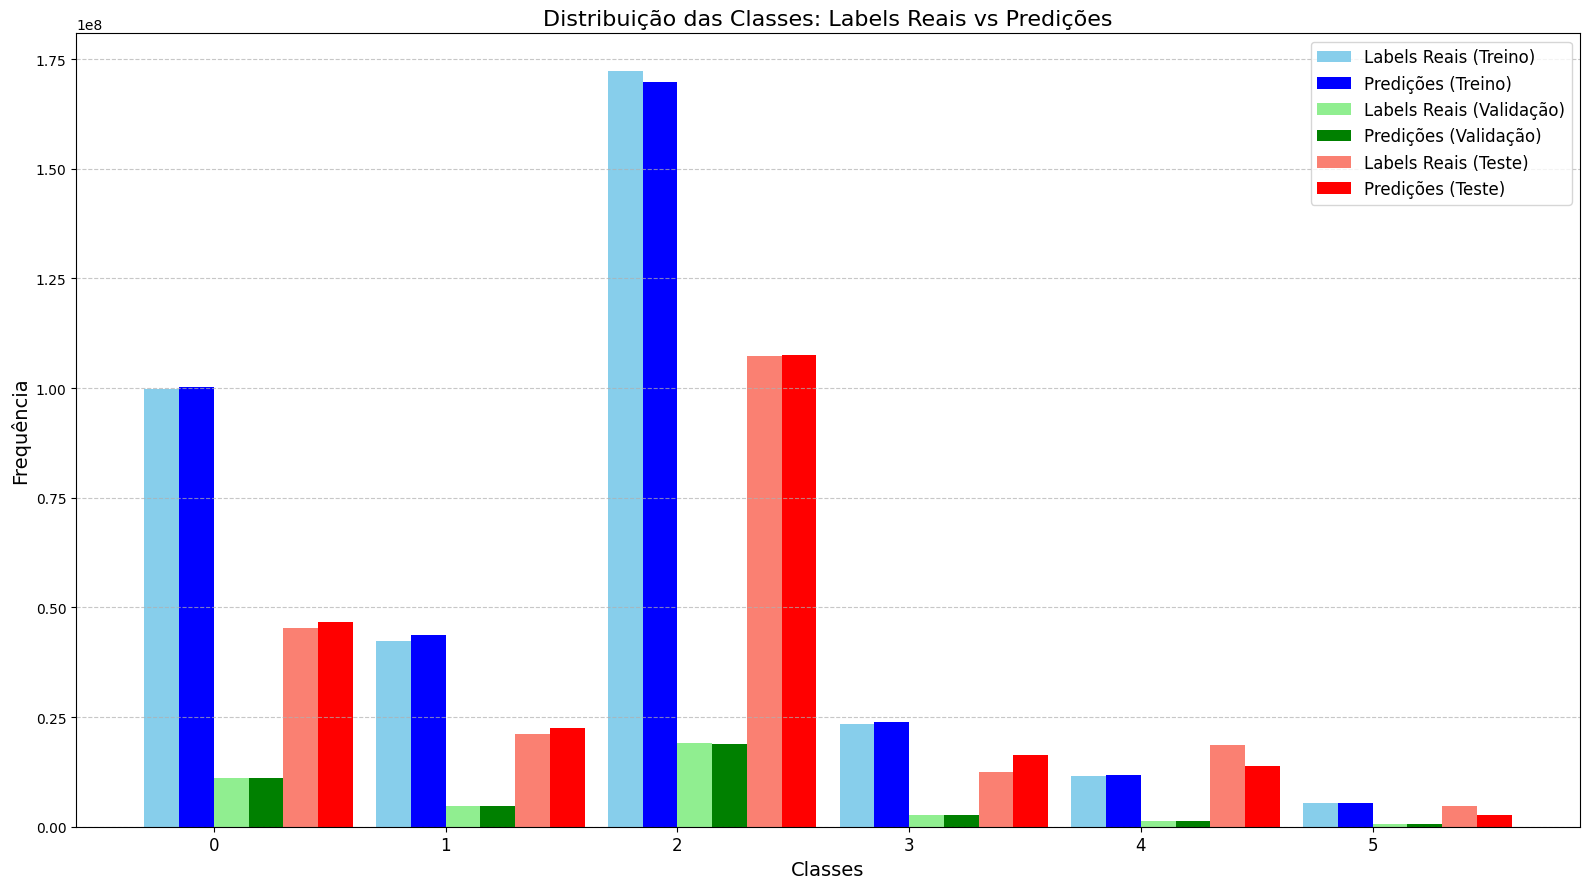

In [16]:
# Configurações para o gráfico de barras lado a lado com espaçamento maior entre classes
num_classes = len(train_unique_labels)
x = np.arange(num_classes) * 2  # Espaçamento maior entre as classes
width = 0.3  # Largura das barras

# Cria o gráfico
plt.figure(figsize=(16, 9))

# Adiciona as barras para as labels reais e predições, lado a lado
plt.bar(x - 1.5 * width, train_counts_labels, width, label="Labels Reais (Treino)", color='skyblue')
plt.bar(x - 0.5 * width, train_counts_preds, width, label="Predições (Treino)", color='blue')

plt.bar(x + 0.5 * width, val_counts_labels, width, label="Labels Reais (Validação)", color='lightgreen')
plt.bar(x + 1.5 * width, val_counts_preds, width, label="Predições (Validação)", color='green')

plt.bar(x + 2.5 * width, test_counts_labels, width, label="Labels Reais (Teste)", color='salmon')
plt.bar(x + 3.5 * width, test_counts_preds, width, label="Predições (Teste)", color='red')

# Configurações do gráfico
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.title("Distribuição das Classes: Labels Reais vs Predições", fontsize=16)
plt.xticks(x, train_unique_labels, fontsize=12)  # Ajusta os rótulos das classes para o eixo X
plt.legend(fontsize=12, loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostra o gráfico
plt.show()

### Usando nova versão de patches (tolstaya)

In [1]:
import lightning as L
import numpy as np
from scipy.ndimage import gaussian_gradient_magnitude, laplace
import torch
import torch.nn.functional as F
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.transforms.transform import _Transform
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pathlib import Path
import os
import random
import gc

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


In [2]:
# f3
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

In [3]:
class PatchingTolstayaModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        patch_size: int = 255,
        stride: int = 32,
        batch_size: int = 8,
        transforms: _Transform = None,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.stride = stride
        self.num_workers = num_workers if num_workers else os.cpu_count()

        self.datasets = {}

    # função útil
    def normalize_data(self, data, target_min=-1, target_max=1):
        """
        Função responsável por normalizar as imagens no intervalo (-1,1)
        """
        data_min, data_max = data.min(), data.max()
        return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)

    # função útil
    def generate_depth_channel(self, shape):
        """
        Função responsável por criar o canal de profundidade, com 0 no topo e 1 na base.
        """
        depth_channel = np.linspace(0, 1, shape[0]).reshape(-1, 1)
        return np.tile(depth_channel, (1, shape[1]))
    
    # função útil
    def extract_patches(self, data, patch_size=255, stride=32, img_type='image'):
        patches = []
        if img_type == 'image': # caso seja imagens de entrada (h, w, c)
            h, w, _ = data.shape
        else: # caso seja labels de entrada (h, w)
            h, w = data.shape
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                patch = data[i:i + patch_size, j:j + patch_size]
                if img_type == 'image':
                    patches.append(patch.transpose(2, 0, 1).astype(np.float32)) # o SAM só recebe (C H W)
                else:
                    patches.append(patch.astype(np.int64))
        return np.array(patches)
    
    # funcao utils
    def generate_facies_probability_channel(self, patch, facies_probabilities):
        prob_map = np.random.choice(
            len(facies_probabilities), size=patch.shape, p=facies_probabilities
            )
        return prob_map

    # funcao util
    def generate_amplitude_gradient_channel(self, patch):
        # Usa gradiente de amplitude com suavização
        gradient_channel = gaussian_gradient_magnitude(patch, sigma=1)
        return gradient_channel / np.max(gradient_channel)  # Normalização

    # funcao util
    def generate_curvature_channel(self, patch):
        # Calcula a curvatura usando o filtro de Laplace
        curvature_channel = laplace(patch)
        return curvature_channel / np.max(np.abs(curvature_channel))  # Normaliza para [-1, 1]

    # função útil
    def generate_image_with_depth(self, normalized_images):
        two_channel_images = []
        for img in normalized_images:  # Garantir que está trabalhando com imagens normalizadas
            depth_channel = self.generate_depth_channel(img.shape[:2])  # Gerar canal de profundidade para esta imagem

            if img.shape[-1] > 1:  # Se a imagem tiver múltiplos canais
                # Escolher apenas o primeiro canal (exemplo, pode ser qualquer canal)
                img = img[:, :, 0:1]  # Seleciona o primeiro canal e mantém as dimensões (H, W, 1)
            
            # gerando canal 3 (teste)
            # facies_probabilities = np.array([0.2857, 0.1207, 0.4696, 0.0747, 0.0361, 0.0132])
            # canal_3 = self.generate_facies_probability_channel(img, facies_probabilities)
            # canal_3 = self.generate_amplitude_gradient_channel(img)
            # canal_3 = self.generate_curvature_channel(img)

            # Concatenar o primeiro canal com o depth_channel
            depth_channel = np.expand_dims(depth_channel, axis=-1)  # Tornar (H, W, 1)
            two_channel_image = np.concatenate((img, depth_channel), axis=-1)  # Concatenar ao longo do eixo dos canais
            two_channel_images.append(two_channel_image)  # Adicionar ao array final
        return two_channel_images
    
    # função util
    def horizontal_flip(self, image, label):
        if not isinstance(image, np.ndarray):
            raise ValueError(f"Experado image com type <class 'numpy.ndarray'>, mas foi recebido {type(image)}")
        if not isinstance(label, np.ndarray):
            raise ValueError(f"Experado label com type <class 'numpy.ndarray'>, mas foi recebido {type(label)}")

        if image.shape[0] != 3 or image.shape[1] != self.patch_size or image.shape[2] != self.patch_size:
            raise ValueError(f"Experado image com shape (C=3 H=patch_size W=patch_size), mas foi recebido {image.shape}")
        if label.shape[0] != self.patch_size or label.shape[1] != self.patch_size:
            raise ValueError(f"Experado label com shape (H=patch_size W=patch_size), mas foi recebido {label.shape}")

        image_flipped = np.flip(image, axis=2)
        label_flipped = np.flip(label, axis=1)

        # if any(s < 0 for s in image_flipped.strides):
        #     print(f"array com strides negativos detectado")

        return image_flipped.copy(), label_flipped.copy()
    
    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "train")] # lendo imagens e normalizando
            train_label_reader = PNGReader(self.annotations_path / "train")
            
            # Gerar imagens com canais de profundidade
            # train_img_reader = self.generate_image_with_depth(train_img_reader)
            
            # Gerar patches em batches
            patches_img_generator = []
            for image in train_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in train_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            # """ augmentation """
            # # Aplicar augmentações nas imagens e labels, somente para as amostras com 3, 4 ou 6 classes
            # augmented_img_generator = []
            # augmented_label_generator = []
            # for img, label in zip(patches_img_generator, patches_label_generator):
            #     # TODO tá estourando nessa parte
            #     augmented_img_generator.append(img)
            #     augmented_label_generator.append(label)
            #     # Verificar o número de classes na amostra
            #     unique_classes = np.unique(label)
            #     num_classes = len(unique_classes)
                
            #     if num_classes in [3, 4, 6]:  # Apenas aplicar augmentação nas amostras com 3, 4 ou 6 classes
            #         img_horizontal_flip, label_horizontal_flip = self.horizontal_flip(img, label)
            #         augmented_img_generator.append(img_horizontal_flip)
            #         augmented_label_generator.append(label_horizontal_flip)
            
            # Criar dataset para treinamento
            self.datasets["train"] = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del train_img_reader, train_label_reader
            del patches_img_generator, patches_label_generator
            # del augmented_img_generator, augmented_label_generator
            gc.collect()

            val_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "val")]
            val_label_reader = PNGReader(self.annotations_path / "val")

            # gerar imagens com canais de profundidade
            # val_img_reader = self.generate_image_with_depth(val_img_reader)

            # Gerar patches em batches
            patches_img_generator = []
            for image in val_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in val_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            self.datasets["val"] = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del val_img_reader, val_label_reader
            del patches_img_generator, patches_label_generator
            gc.collect()
        
        elif stage == "test" or stage == "predict":
            test_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "test")]
            test_label_reader = PNGReader(self.annotations_path / "test")

            # gerar imagens com canais de profundidade
            # test_img_reader = self.generate_image_with_depth(test_img_reader)

            # Gerar patches em batches
            patches_img_generator = []
            for image in test_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in test_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            test_dataset = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del test_img_reader, test_label_reader
            del patches_img_generator, patches_label_generator
            gc.collect()

            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True, 
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def worker_init_fn(self, worker_id):
        random.seed(18 + worker_id)

In [4]:
from lightning.pytorch import LightningModule

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

data_module = PatchingTolstayaModule(
    train_path=train_path,
    annotations_path=annotation_path,
    patch_size=255,
    stride=32,
    batch_size=8
)

# Carregar o modelo salvo
best_checkpoint = "checkpoints/tolstaya-sam_model-2024-11-22-epoch=43-val_loss=0.14.ckpt"  # teste
trained_model = SAMLoRA.load_from_checkpoint(
    checkpoint_path=best_checkpoint,
    image_size=255,
    num_classes=5, # considera 6 pois internamente o sam faz +1 pro background
    # pixel_mean=[123.675, 116.28],
    # pixel_std=[58.395, 57.12],
    alpha=1,
    rank=4,
    # apply_lora_vision_encoder=apply_lora_vision_encoder,
    # apply_lora_mask_decoder=apply_lora_mask_decoder,
    # frozen_vision_encoder=frozen_vision_encoder,
    # frozen_prompt_encoder=frozen_prompt_encoder,
    # frozen_mask_decoder=frozen_mask_decoder,
    # vit_model=vit_model,
    # checkpoint=checkpoint_path,
    # train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
).to(device)

cuda
Focal loss alpha=0.25, will shrink the impact in background


In [5]:
num_classes = 6

In [6]:
import torch
from torchmetrics.classification import MulticlassJaccardIndex
import torchmetrics
import numpy as np

def calculate_metrics(dataloader, model, num_classes):
    model.eval()  # Define o modelo em modo de avaliação
    iou_metric = MulticlassJaccardIndex(num_classes=num_classes, average=None).to(model.device)
    # iou_metric = torchmetrics.JaccardIndex(task="multiclass", num_classes=num_classes).to(model.device)
    
    class_counts = torch.zeros(num_classes, dtype=torch.int32)  # Contagem das classes por amostra
    class_iou = torch.zeros(num_classes, dtype=torch.float32)  # IoU de cada classe
    all_labels = []  # Lista para armazenar todas as labels
    all_preds = []  # Lista para armazenar todas as previsões

    with torch.no_grad():
        for batch in dataloader:
            # low_res = model.img_embedding_size * 4
            image_batch, label_batch = batch[0].to(model.device), batch[1].to(model.device)
            # print("-"*20)
            # print(image_batch.shape)
            # print(label_batch.shape)
            # print("-"*20)
            # label_batch = label_batch  # .squeeze(1)  # Remove a dimensão extra
            # low_res_label_batch = model.make_low_res_label(label=label_batch, low_res=[low_res, low_res]) # batch["low_res_label"]
          
            # Predição
            outputs = model(image_batch, True, image_size=model.image_size)
            # print("mask shape: ", outputs['masks'].shape)

            probs = torch.softmax(outputs['masks'], dim=1)
            preds = torch.argmax(probs, dim=1)  # Obtém a classe predita para cada pixel
            # print("shape preds: ", preds.shape)
            # print("shape preds[0]: ", preds[0].shape)

            # Atualiza o IoU para cada classe
            iou_per_class = iou_metric(preds, label_batch).cpu()
            # print("iou_per_class: ", iou_per_class)
            # print("Frequência em preds:", torch.bincount(preds.flatten(), minlength=num_classes))
            # print("Frequência em labels:", torch.bincount(label_batch.flatten(), minlength=num_classes))

            class_iou += iou_per_class

            # Atualiza a distribuição das classes
            for c in range(num_classes):
                class_counts[c] += torch.sum(preds == c).item()

            # Armazena todas as labels e previsões para análise posterior
            all_labels.append(label_batch.flatten())
            all_preds.append(preds.flatten())
    
    # Concatena todas as labels e previsões para calcular as frequências das classes
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_preds = torch.cat(all_preds).cpu().numpy()

    unique_labels, counts_labels = np.unique(all_labels, return_counts=True)  # Frequência por classe
    unique_preds, counts_preds = np.unique(all_preds, return_counts=True)  # Frequência por classe

    # Calcula o IoU por classe
    class_iou = class_iou / len(dataloader)  # Divide pelo número de batches

    # Distribuição das classes
    class_distribution = class_counts / class_counts.sum()

    return class_iou, class_distribution, unique_labels, counts_labels, unique_preds, counts_preds

In [7]:
# DataLoaders
data_module.setup(stage='fit')
train_loader = data_module.train_dataloader()

# Métricas para treino
train_iou, train_distribution, train_unique_labels, train_counts_labels, train_unique_preds, train_counts_preds = calculate_metrics(train_loader, trained_model, num_classes)
print("Train IoU:", train_iou)
print("Train Class Distribution:", train_distribution)
print("Test count labels:", train_counts_labels)

del train_loader

Train IoU: tensor([0.9806, 0.8970, 0.9718, 0.8636, 0.8484, 0.8089])
Train Class Distribution: tensor([0.2849, 0.1237, 0.4702, 0.0718, 0.0364, 0.0130])
Test count labels: [152541704  63299816 256085985  37365370  17787838   6644487]


In [8]:
# DataLoaders
# data_module.setup(stage='fit')
val_loader = data_module.val_dataloader()

# Métricas para validação
val_iou, val_distribution, val_unique_labels, val_counts_labels, val_unique_preds, val_counts_preds = calculate_metrics(val_loader, trained_model, num_classes)
print("Validation IoU:", val_iou)
print("Validation Class Distribution:", val_distribution)
print("Test count labels:", val_counts_labels)

del val_loader

Validation IoU: tensor([0.9801, 0.8922, 0.9701, 0.8297, 0.6308, 0.3640])
Validation Class Distribution: tensor([0.2831, 0.1224, 0.4712, 0.0721, 0.0386, 0.0127])
Test count labels: [16803104  6941325 28476146  4147867  2080643   723665]


In [9]:
# DataLoaders
data_module.setup(stage='test')
test_loader = data_module.test_dataloader()

# Métricas para teste
test_iou, test_distribution, test_unique_labels, test_counts_labels, test_unique_preds, test_counts_preds = calculate_metrics(test_loader, trained_model, num_classes)
print("Test IoU:", test_iou)
print("Test Class Distribution:", test_distribution)
print("Test count labels:", test_counts_labels)

del test_loader

Test IoU: tensor([0.9693, 0.8519, 0.9579, 0.5160, 0.4302, 0.3201])
Test Class Distribution: tensor([0.2212, 0.1080, 0.5157, 0.0815, 0.0667, 0.0068])
Test count labels: [ 72472755  32813736 170229505  15171240  31700080   2737684]


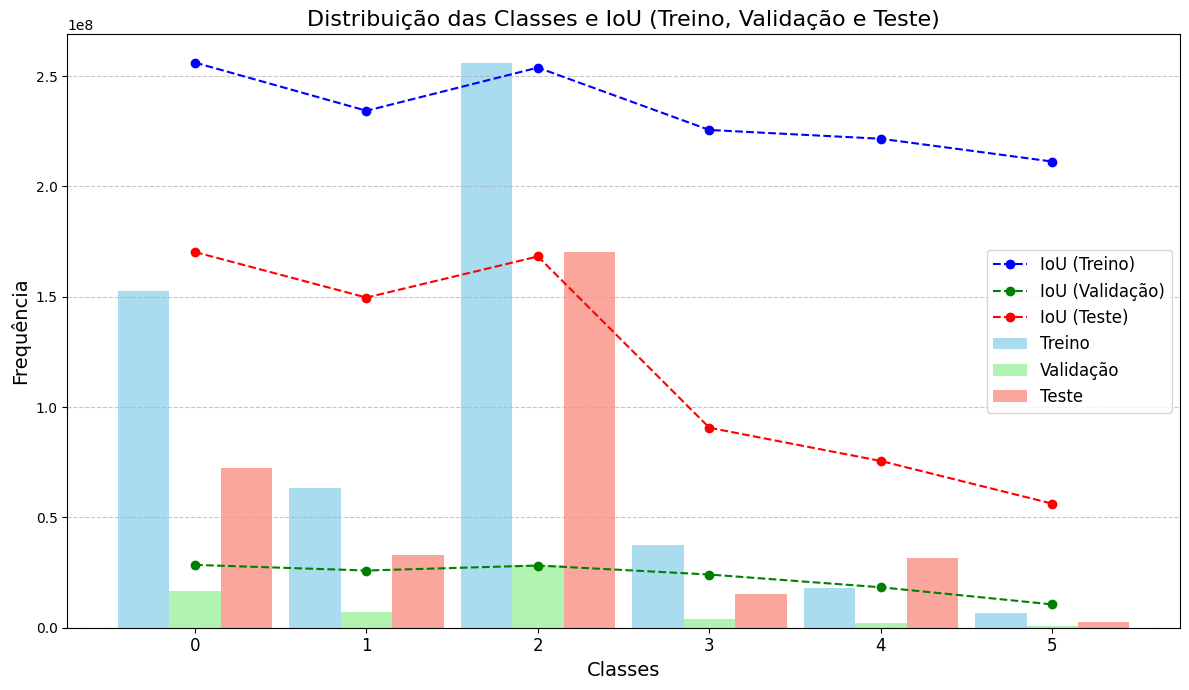

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Configurações para o gráfico de barras e linha
x = np.arange(len(train_unique_labels))  # Posições para as classes
width = 0.3  # Largura das barras

plt.figure(figsize=(12, 7))

# Adiciona as barras para cada conjunto
plt.bar(x - width, train_counts_labels, width, label="Treino", color='skyblue', alpha=0.7)
plt.bar(x, val_counts_labels, width, label="Validação", color='lightgreen', alpha=0.7)
plt.bar(x + width, test_counts_labels, width, label="Teste", color='salmon', alpha=0.7)

# Adiciona a linha para o IoU (normalize para comparação visual)
plt.plot(x, train_iou / train_iou.max() * max(train_counts_labels), 
         label="IoU (Treino)", color='blue', linestyle='--', marker='o')
plt.plot(x, val_iou / val_iou.max() * max(val_counts_labels), 
         label="IoU (Validação)", color='green', linestyle='--', marker='o')
plt.plot(x, test_iou / test_iou.max() * max(test_counts_labels), 
         label="IoU (Teste)", color='red', linestyle='--', marker='o')

# Configurações do gráfico
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.title("Distribuição das Classes e IoU (Treino, Validação e Teste)", fontsize=16)
plt.xticks(x, train_unique_labels, fontsize=12)  # Define os rótulos das classes no eixo X
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostra o gráfico
plt.show()

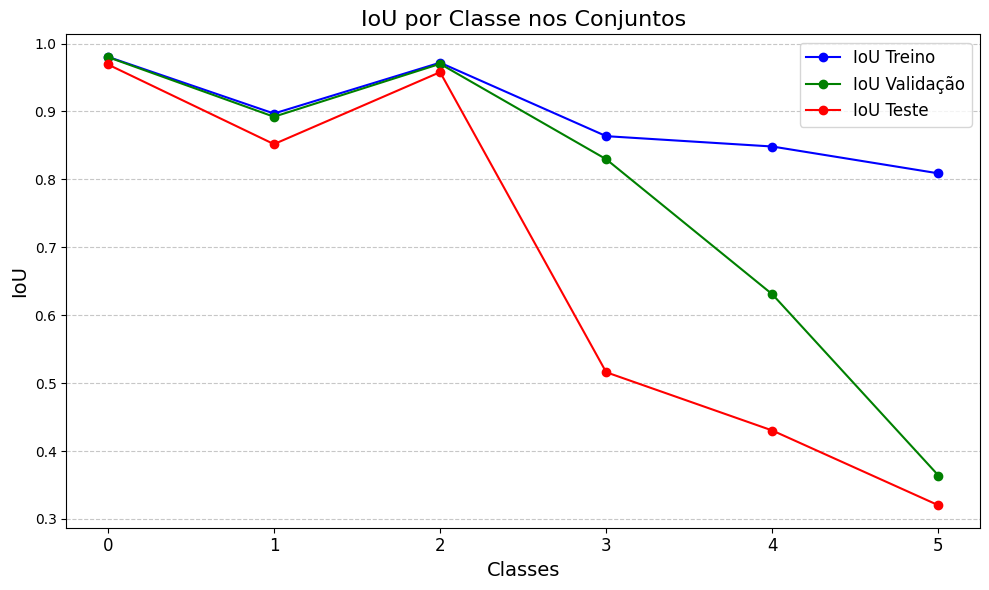

In [11]:
# IoU por classe
x = np.arange(len(train_iou))  # Posições para as classes

plt.figure(figsize=(10, 6))

# Linhas para IoU
plt.plot(x, train_iou, label="IoU Treino", color='blue', marker='o')
plt.plot(x, val_iou, label="IoU Validação", color='green', marker='o')
plt.plot(x, test_iou, label="IoU Teste", color='red', marker='o')

# Configurações do gráfico
plt.xlabel("Classes", fontsize=14)
plt.ylabel("IoU", fontsize=14)
plt.title("IoU por Classe nos Conjuntos", fontsize=16)
plt.xticks(x, train_unique_labels, fontsize=12)  # Define os rótulos das classes no eixo X
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

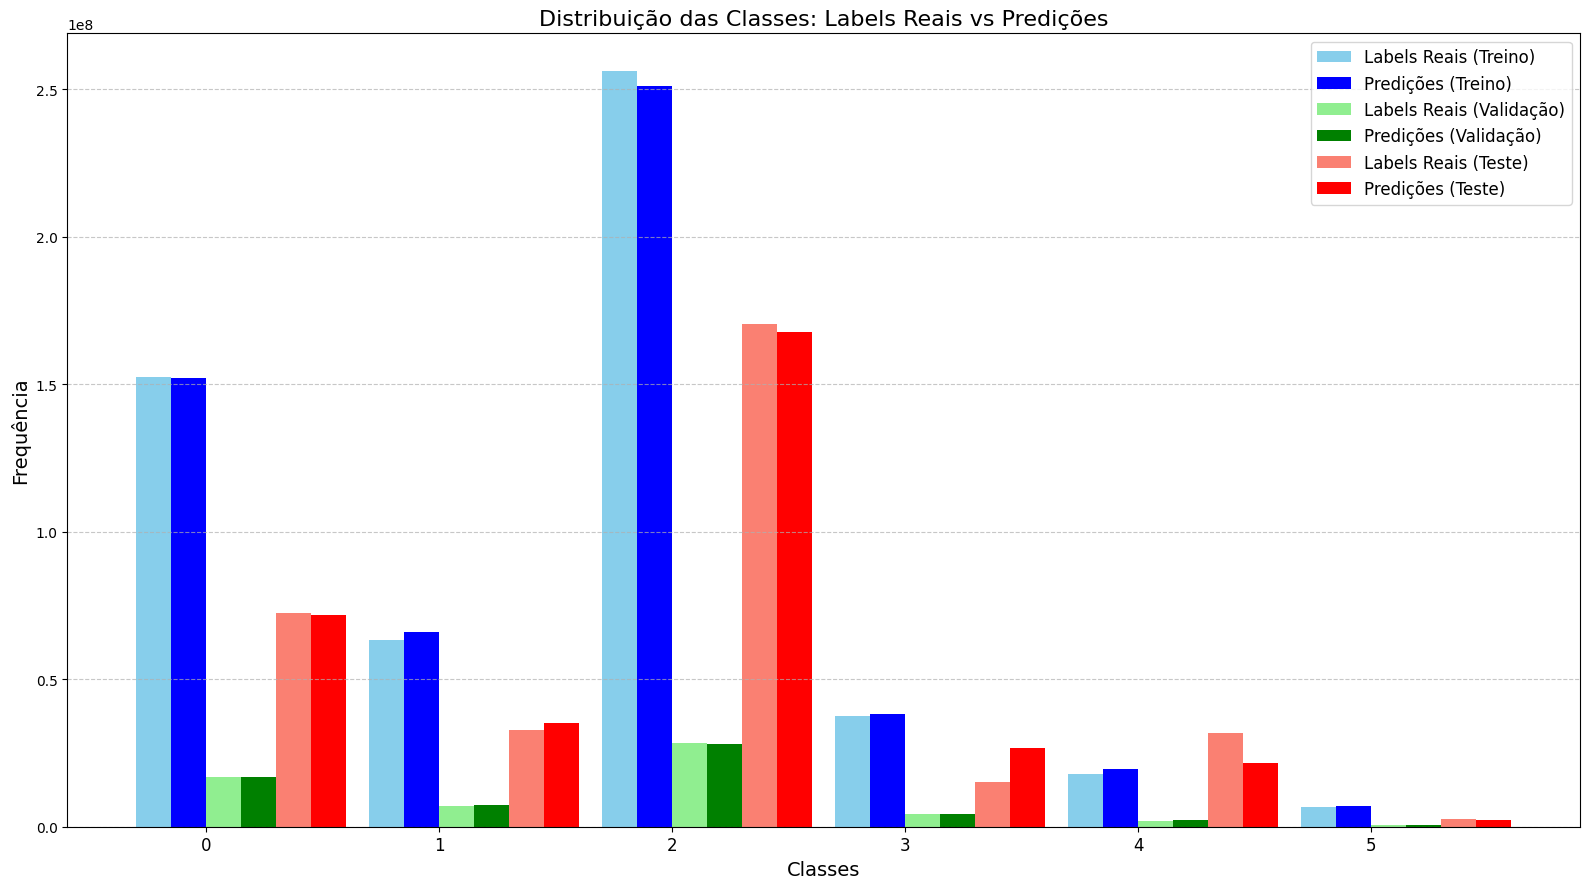

In [12]:
# Configurações para o gráfico de barras lado a lado com espaçamento maior entre classes
num_classes = len(train_unique_labels)
x = np.arange(num_classes) * 2  # Espaçamento maior entre as classes
width = 0.3  # Largura das barras

# Cria o gráfico
plt.figure(figsize=(16, 9))

# Adiciona as barras para as labels reais e predições, lado a lado
plt.bar(x - 1.5 * width, train_counts_labels, width, label="Labels Reais (Treino)", color='skyblue')
plt.bar(x - 0.5 * width, train_counts_preds, width, label="Predições (Treino)", color='blue')

plt.bar(x + 0.5 * width, val_counts_labels, width, label="Labels Reais (Validação)", color='lightgreen')
plt.bar(x + 1.5 * width, val_counts_preds, width, label="Predições (Validação)", color='green')

plt.bar(x + 2.5 * width, test_counts_labels, width, label="Labels Reais (Teste)", color='salmon')
plt.bar(x + 3.5 * width, test_counts_preds, width, label="Predições (Teste)", color='red')

# Configurações do gráfico
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.title("Distribuição das Classes: Labels Reais vs Predições", fontsize=16)
plt.xticks(x, train_unique_labels, fontsize=12)  # Ajusta os rótulos das classes para o eixo X
plt.legend(fontsize=12, loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostra o gráfico
plt.show()

### Inferencia - Tolstaya (janeja deslizante)

In [1]:
import lightning as L
import numpy as np
from scipy.ndimage import gaussian_gradient_magnitude, laplace
import torch
import torch.nn.functional as F
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.transforms.transform import _Transform
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pathlib import Path
import os
import random
import gc

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


In [2]:
# f3
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

In [3]:
num_classes = 6

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Carregar o modelo salvo
best_checkpoint = "checkpoints/tolstaya-sam_model-2024-11-22-epoch=43-val_loss=0.14.ckpt"  # teste
trained_model = SAMLoRA.load_from_checkpoint(
    checkpoint_path=best_checkpoint,
    image_size=255,
    num_classes=num_classes-1, # considera 6 pois internamente o sam faz +1 pro background
    alpha=1,
    rank=4,
).to(device)

cuda
Focal loss alpha=0.25, will shrink the impact in background


In [4]:
def normalize_data(data, target_min=-1, target_max=1):
    """
    Função responsável por normalizar as imagens no intervalo (-1,1)
    """
    data_min, data_max = data.min(), data.max()
    return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)

test_img_reader = [normalize_data(image) for image in TiffReader(Path(train_path) / "test")]
test_label_reader = PNGReader(Path(annotation_path) / "test")

In [5]:
sample_img = test_img_reader[0]
sample_label = test_label_reader[0]

In [6]:
def plot_img_and_label(img, label):
    # Criar a figura com dois subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Exibir a primeira imagem (colorida)
    axes[0].imshow(img)
    axes[0].axis('off')  # Remove os eixos
    axes[0].set_title('Imagem Colorida')

    # Exibir a segunda imagem (escala de cinza)
    axes[1].imshow(label, cmap='gray')
    axes[1].axis('off')  # Remove os eixos
    axes[1].set_title('Imagem Escala de Cinza')

    # Exibir a figura
    plt.tight_layout()
    plt.show()

def plot_label_and_pred(label, pred):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(label, cmap='gray')
    axes[0].axis('off')  # Remove os eixos
    axes[0].set_title('Label')

    axes[1].imshow(pred, cmap='gray')
    axes[1].axis('off')  # Remove os eixos
    axes[1].set_title('Preds')

    # Exibir a figura
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


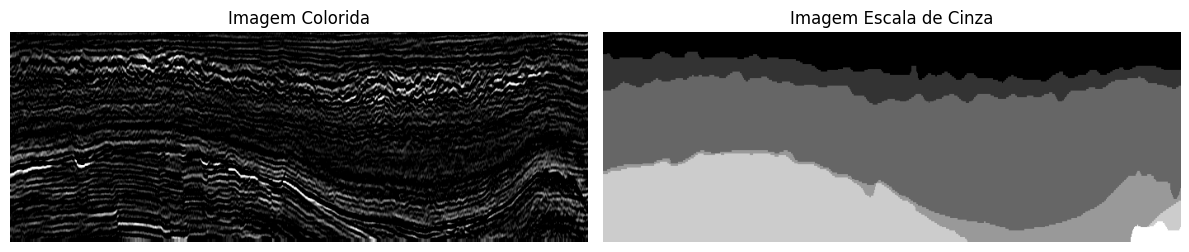

In [7]:
plot_img_and_label(sample_img, sample_label)

In [8]:
def sliding_window_inference(data, label, model, patch_size=255, stride=2, reflection_width=None):
    h, w, _ = data.shape
    preds = np.zeros((h, w))
    counts = np.zeros((h, w))

    # Adiciona reflexão nas bordas (opcional)
    if reflection_width:
        reflected_data = np.pad(data, ((reflection_width, reflection_width), 
                                       (reflection_width, reflection_width), 
                                       (0, 0)), mode='reflect')
    else:
        reflected_data = data
    
    # debug
    # plot_img_and_label(reflected_data, label)

    # Desliza a janela
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch_img = reflected_data[i:i + patch_size, j:j + patch_size]
            patch_label = label[i:i + patch_size, j:j + patch_size]
            # plot_img(patch_img, patch_label)
            patch_tensor = torch.tensor(patch_img.transpose(2, 0, 1), dtype=torch.float32)  # Reordena para (3, altura, largura)
            patch_tensor = patch_tensor.unsqueeze(0).to(device)  # Adiciona a dimensão do batch, transformando em (1, 3, altura, largura)
            
            # debug
            # print("patch_tensor shape: ", patch_tensor.shape)
            
            # Previsão do modelo
            outputs = model(patch_tensor, True, image_size=model.image_size)
            probs = torch.softmax(outputs['masks'], dim=1)
            pred = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()

            # debug
            # print(pred.shape)
            # print(outputs['masks'].squeeze().detach().cpu().numpy().shape)
            # print("preds shape: ", preds.shape)
            # plot_label_and_pred(patch_label, pred)
            
            # Soma as predições para a média posterior
            preds[i:i + patch_size, j:j + patch_size] += pred
            counts[i:i + patch_size, j:j + patch_size] += 1

    # debug
    # plot_label_and_pred(label, preds)
    # Retorna a média das predições
    return preds / counts

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


resultado:  (255, 701)


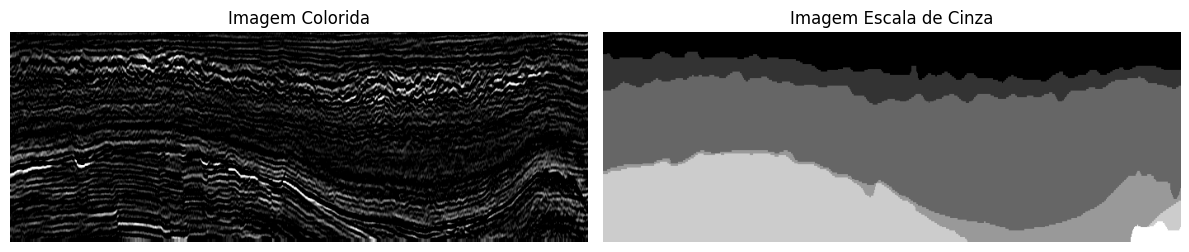

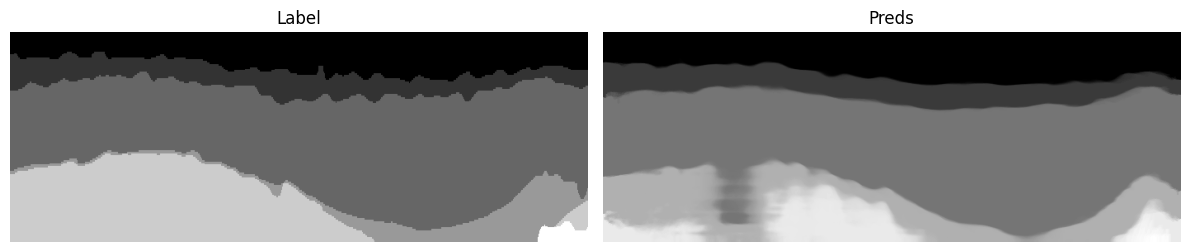

In [9]:
patch_size = 255
stride = 1
reflection_width = 8  # Reflexão nas bordas

resultado = sliding_window_inference(sample_img, sample_label, trained_model, patch_size=patch_size, stride=stride, reflection_width=reflection_width)
print("resultado: ", resultado.shape)
plot_img_and_label(sample_img, sample_label)
plot_label_and_pred(sample_label, resultado)